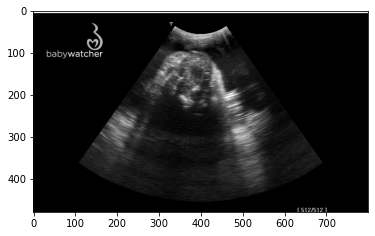

In [1]:
import os, random
import cv2
import matplotlib.pyplot as plt

os.chdir('..')
os.chdir('../resources')
pwd = os.getcwd()

img_name = random.choice(os.listdir(pwd+'/images/1'))

original_image = cv2.imread(pwd+'/images/1/'+img_name, 0)
plt.imshow(original_image, cmap='gray')

# I. Apply Image pre-processing/filtering
### 1. Crop outside part of image

Original shape (480, 800) 
New Shape (416, 520)


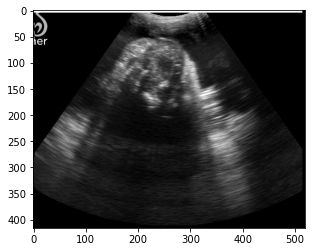

In [2]:
import numpy as np
import pandas as pd

# to_crop = 2D grayscale image array
# threshold = [0-1] maximum 0s in row/col
# Removes parts of to_crop that have less than *threshold* information and pads array to shape divisible 8
def crop_low_info(to_crop, threshold):
    cropped = pd.DataFrame(to_crop)
    cropped = cropped.replace([0],np.nan)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=1)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=0)
    cropped = cropped.replace(np.nan,0).astype(np.uint8)
    cropped = np.pad(cropped, [(0, 8-cropped.shape[0]%8), (0, 8-cropped.shape[1]%8)], mode='constant', constant_values=0)
    return cropped


cropped_image = crop_low_info(original_image, 0.2)
print('Original shape {} \nNew Shape {}'.format(original_image.shape,cropped_image.shape))
plt.imshow(cropped_image, cmap='gray')

### 2. Apply filters

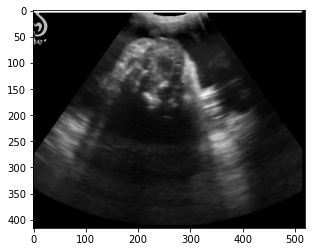

In [4]:
from PIL import Image, ImageEnhance

# Adjust brightness
def brighten(to_brighten, amount):
    to_brighten = Image.fromarray(to_brighten)
    converter = ImageEnhance.Brightness(to_brighten)
    return np.asarray(converter.enhance(amount))

def sharpen(to_sharpen, amount):
    to_sharpen = Image.fromarray(to_sharpen)
    converter = ImageEnhance.Sharpness(to_sharpen)
    return np.asarray(converter.enhance(amount))
  
def blur(to_blur, size):
    return cv2.medianBlur(to_blur, size)

def apply_filters(image, brighten_strength, median_size, sharpen_strength, steps=False):
    bright = brighten(image, brighten_strength)
    median = blur(bright, median_size)
    sharp = sharpen(median, sharpen_strength)
    return (bright, median, sharp) if steps else sharp


processed_image = apply_filters(cropped_image,1,5,2, steps=False)
plt.imshow(processed_image, cmap='gray')

### 3. Whole pre-processing pipeline

In [6]:
# Already filled in with magic variables. None of these are set
def process_image(image):
    cropped = crop_low_info(image, 0.2)
    filtered = apply_filters(cropped, brighten_strength = 1, median_size = 5, sharpen_strength = 2, steps=False)
    return filtered

processed_image = process_image(original_image)

# II. Feature recognition pipeline

### 1. Slide different size window over image
Make all sliding windows square. Including for long features (e.g spine, legs, arms)

### TODO vectorize for speed (not a priority)

In [8]:
%%time
# Input image and window_size
# Returns list of window_size sub-section of whole image
def get_window_coords(x, y, size):
    return np.ix_(np.arange(x, x+size),np.arange(y, y+size))

def get_windows(image, window_size, win_stride = 1):
    # x, y and size are int
    # window is list/np array
    windows = []
    x_arr = []
    y_arr = []
    for x in range(0, image.shape[0]-window_size+1, win_stride):
        for y in range(0, image.shape[1]-window_size+1, win_stride):
            window = image[get_window_coords(x, y, window_size)]
            x_arr.append(x)
            y_arr.append(y)
            windows.append(window)
    windows = pd.DataFrame({'x': x_arr, 'y': y_arr, 'window_size': [window_size]*len(y_arr), 'window':windows})
    return windows


windows = get_windows(processed_image, 64, win_stride = 16)
print('{} windows were made'.format(len(windows)))

667 windows were made
Wall time: 13 ms


In [9]:
def show_video(frames, title=None):
    i = 0
    t = 'frame'
    while(True):
        gray = frames[i]
        i = (i+1)%len(frames)
        if(title is not None):
            t = title[i]
        cv2.imshow(t,gray)
        k = cv2.waitKey(2000)
        if k == 27:         # If escape was pressed exit
            cv2.destroyAllWindows()
            break

#show_video(windows)

### 2. Apply HOG to all windows

- For each feature:  
    - For each window: 
        - Resize to (128, 128)
        - Apply HOG
        - Save HOG

### TODO vectorize for speed (not a priority)

In [23]:
%%time
from skimage.feature import hog

def compute_hog(window):
    w = cv2.resize(window, (128, 128))
    fd = hog(w, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(4, 4),block_norm= 'L2')
    return np.reshape(fd, (1, -1))

windows['hog'] = windows['window'].apply(compute_hog)
print('{} HOG features per window'.format(windows.loc[0]['hog'].shape))

(1, 3200) HOG features per window
Wall time: 996 ms


### 4. Train Classifiers

Read images of known features

In [95]:
%%time
features = []
pixels = []
img_names = []
for feature in ['head', 'spine', 'leg', 'arm', 'hand', 'foot']:
    file_names = os.listdir(pwd+'/features/'+feature)
    img_names = img_names + file_names
    for file in file_names:
        features.append(feature)
        pixels.append(cv2.imread(pwd+'/features/'+feature+'/'+file, 0))

feature_images = pd.DataFrame({'image_name': img_names,'class' : features, 'image_pixels': pixels})
print(feature_images.value_counts('class'))
feature_images.head(5)

class
head     157
spine     33
hand      25
arm       11
foot       9
leg        8
dtype: int64
Wall time: 143 ms


,image_name,class,image_pixels
0,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ..."
1,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93..."
2,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ..."
3,19165_2021-05-19_17.34_173357996.png,head,"[[38, 45, 54, 57, 60, 61, 61, 57, 54, 51, 51, ..."
4,19175_2021-01-12_16.05_1639288.png,head,"[[89, 86, 83, 83, 86, 88, 88, 89, 88, 89, 91, ..."


Feature stats (useless af btw):

In [96]:
width = []
height = []
avg = []
for idx, row in feature_images.iterrows():
    width.append(row['image_pixels'].shape[0])
    height.append(row['image_pixels'].shape[1])
    avg.append(row['image_pixels'].mean())

stats = pd.DataFrame({'width':width, 'height':height, 'mean':avg})
print(stats.describe())

            width      height        mean
count  243.000000  243.000000  243.000000
mean   118.625514  141.283951   86.448440
std     51.548458   52.004267   11.573990
min     31.000000   40.000000   51.344302
25%     76.000000  106.500000   79.278948
50%    118.000000  136.000000   87.171945
75%    145.000000  177.000000   93.346184
max    270.000000  292.000000  123.718703


Resize all to (128, 128)

In [97]:
%%time
def resize(x):
    return cv2.resize(x,(128, 128))

feature_images['resized_pixels'] = feature_images['image_pixels'].apply(resize)
feature_images.head(5)

Wall time: 5 ms


,image_name,class,image_pixels,resized_pixels
0,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ...","[[58, 50, 48, 50, 55, 61, 64, 65, 65, 63, 59, ..."
1,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93...","[[91, 94, 89, 88, 94, 103, 101, 97, 93, 92, 87..."
2,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ..."
3,19165_2021-05-19_17.34_173357996.png,head,"[[38, 45, 54, 57, 60, 61, 61, 57, 54, 51, 51, ...","[[38, 43, 51, 55, 58, 60, 61, 61, 58, 55, 52, ..."
4,19175_2021-01-12_16.05_1639288.png,head,"[[89, 86, 83, 83, 86, 88, 88, 89, 88, 89, 91, ...","[[88, 84, 85, 87, 87, 88, 90, 93, 90, 87, 85, ..."


Compute HOG features

In [98]:
feature_images['hog'] = feature_images['resized_pixels'].apply(compute_hog)
feature_images.head(5)

,image_name,class,image_pixels,resized_pixels,hog
0,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ...","[[58, 50, 48, 50, 55, 61, 64, 65, 65, 63, 59, ...","[[0.04436245446404937, 0.026628690018342605, 0..."
1,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93...","[[91, 94, 89, 88, 94, 103, 101, 97, 93, 92, 87...","[[0.023932959631488865, 0.00981499770810194, 0..."
2,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,19165_2021-05-19_17.34_173357996.png,head,"[[38, 45, 54, 57, 60, 61, 61, 57, 54, 51, 51, ...","[[38, 43, 51, 55, 58, 60, 61, 61, 58, 55, 52, ...","[[0.0384178711132365, 0.013131622446405793, 0...."
4,19175_2021-01-12_16.05_1639288.png,head,"[[89, 86, 83, 83, 86, 88, 88, 89, 88, 89, 91, ...","[[88, 84, 85, 87, 87, 88, 90, 93, 90, 87, 85, ...","[[0.020523334435590884, 0.012203793689375495, ..."


Separate into test and train data
## TODO run tests on different types of regression algorithms/classifiers
### Make sur to separate classfiers (here its a multi-class classifier)

In [99]:
labels =  np.array(feature_images['class']).reshape(len(feature_images['class']),1)
hog_features = np.stack(feature_images['hog'], axis=1)[0]
data = np.hstack((hog_features,labels))

np.random.shuffle(data)
percentage = 80
partition = int(len(data)*percentage/100)

x_train, x_test = data[:partition,:-1],  data[partition:,:-1]
y_train, y_test = data[:partition,-1:].ravel() , data[partition:,-1:].ravel()

In [100]:
%time
from sklearn import svm

clf = svm.SVC(probability=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

Wall time: 0 ns


In [102]:
from sklearn.metrics import classification_report,accuracy_score

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.673469387755102


              precision    recall  f1-score   support

         arm       0.00      0.00      0.00         1
        foot       0.00      0.00      0.00         4
        hand       0.00      0.00      0.00         7
        head       0.65      1.00      0.79        30
       spine       1.00      0.43      0.60         7

    accuracy                           0.67        49
   macro avg       0.33      0.29      0.28        49
weighted avg       0.54      0.67      0.57        49



C:\Users\emery\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emery\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emery\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. Run all HOG features through each pre-trained classfication model
Each feature will have an separate SVM so:
- For each HOG features
    - For each SVM
        - Get match strength of HOG to feature

Filter out matches below threshold and sort by match strength. Highest wins

Low amount of data and high number of features, so we need a classification model that has bias/low variance such as Linear SVM.

https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html

In [103]:
classes = ['head', 'spine', 'leg', 'arm', 'hand', 'foot']
pred_threshold = 0.8

def predict(hog_f):
    pred = clf.predict_proba(np.reshape(hog_f, (1, -1)))[0]
    class_idx = pred.argmax()
    if pred[class_idx]< pred_threshold:
        return 'none'
    return classes[class_idx]

# Full pipeline

In [105]:
%time

low_info = 0.2
bright_strength = 1.5
med_size = 5
sharp_strength = 2
win_size = 64
win_stride = 16

def process_image(image):
    cropped = crop_low_info(image, low_info)
    filtered = apply_filters(cropped, bright_strength, med_size, sharp_strength, steps=False)
    return filtered

def hog_pipeline(image):
    processed = process_image(image)
    windows = get_windows(processed, win_size, win_stride)
    windows['hog'] = windows['window'].apply(compute_hog)
    return windows

windows = hog_pipeline(original_image)
windows['prediction'] = windows['hog'].apply(predict)
windows[windows['prediction']!='none']

Wall time: 0 ns


,x,y,window_size,window,hog,prediction
